# Projeto 1 - Ciência dos Dados

Nome: Danilo Ramos

Nome: Leonardo Veras

Nome: Thomas Ganut

___
<div id="indice"></div>

# Índice
  - [Montando um classificador Naive-Bayes](#naive)
  - [Verificando a performance do Classificador](#performance)
  - [Conclusão](#conclusao)
  - [Referências](#referencias)

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display
import re

Carregando a base de dados com as mensagens dos seus arquivos:

In [2]:
test = pd.read_csv('dados_teste_QUARTETO_Danilo_Leonardo_Thomas.csv')
train = pd.read_csv('dados_treino_QUARTETO_Danilo_Leonardo_Thomas.csv')

print(f'{len(test)}   (Tamanho das listas de treino e teste) ')

1800   (Tamanho das listas de treino e teste) 


___
<div id="clas_auto"></div>

## Classificador automático


Será desenvolvido um sistema automático, utilizando o Teorema de Bayes, para classificar textos científicos em física, química e biologia. Uma prova de conceito será implementada para treinar e testar o classificador, garantindo a separação clara dos textos nas respectivas áreas.

___
<div id="naive"></div>

## Montando um Classificador Naive-Bayes

Criando uma primeira função para limpar os dados:

In [3]:
punctuation = '[´`"!-.:?;$''^~)(&€™/]'

def cleanup(text):
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text).replace(("\\n"),' ')
    return text_subbed

Criando uma série palavra a palavra dos dados de treino e separando Stop Words:

Stop words são palavras do idioma que não indicam nada por si só, apenas servem para construir uma frase com sentido, como as palavras "there", "we" e "do".

É ums estratégia interessante fazer a retidade de Stop Words para melhorar a performance do nosso classificador, como está explícito no texto "Naive Bayes and Text Classification I Introduction and Theory" do autor Sebastian Raschka, disponível em: https://arxiv.org/pdf/1410.5329

Ao mesmo tempo, foi considerado a estratégia de tokenização e N-gramas, mostradas no mesmo texto elencado acima.

In [4]:
# Define stop words

list_train: list = []

n = 1 # Número de N-gramas - melhor performance foi com 1, mas explicamos isso na conclusão

for frase in train.Comment:
    frase = cleanup(frase)
    frase = frase.split()
    if len(frase) < 1:  # Teste tirando as frases muito curtas - não fez diferença
        continue
    list_train.extend([' '.join(frase[i:i+n]) for i in range(len(frase)-n+1)])
        
serie_train = pd.Series(list_train)
print('Quantidade de palavras na base de dados de treinamento: ', len(serie_train))
tabela = serie_train.value_counts()

stop_words = tabela.index[:40].tolist()
for i in range(len(stop_words)):
    stop_words[i] = stop_words[i].lower()
print('Lista de stop-words:', stop_words)


Quantidade de palavras na base de dados de treinamento:  149064
Lista de stop-words: ['the', 'to', 'a', 'of', 'and', 'is', 'i', 'in', 'it', 'you', 'that', 'for', 'be', 'are', 'with', 'not', 'but', 'have', 'on', 'this', 'as', 'or', 'can', 'your', 'would', 'if', 'from', 'just', 'an', 'like', 'so', 'at', 'the', 'was', 'they', 'more', 'its', 'my', 'what', 'about']


In [5]:
# Definindo uma função de limpeza das frases com as Stop Words

def cleanup_stopwords(frase, stop_words):
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', frase.lower())
    text_subbed = text_subbed.replace(("\\n"),' ').replace(("\n"),' ')
    for palavra in stop_words:
        text_subbed = text_subbed.replace((f' {palavra} '), ' ')

    return text_subbed

In [6]:
# Limpando os dados de treinamento

for i, frase in enumerate(train.Comment):
    train.Comment[i] = cleanup_stopwords(frase.lower(), stop_words)

# Construindo uma série de N-gramas baseado nos dados de treino limpos

list_train: list = []

for frase in train.Comment:
    frase = frase.split()
    list_train.extend([' '.join(frase[i:i+n]) for i in range(len(frase)-n+1)])
        
serie_train = pd.Series(list_train)

In [7]:
#Separando as matérias do dataframe com filtros

train_physics = train.loc[train.Topic == 'Physics']
train_biology = train.loc[train.Topic == 'Biology']
train_chemistry = train.loc[train.Topic == 'Chemistry']

In [8]:
# Função para transformar frases em lista de palavras
def frase_para_palavras(lista_frases):
    lista_palavras = []
    for frase in lista_frases:
        lista_palavras.extend(frase.split())
    return lista_palavras

# Gerando as listas de palavras por tópico
lista_physics = frase_para_palavras(train_physics.Comment)
lista_biology = frase_para_palavras(train_biology.Comment)
lista_chemistry = frase_para_palavras(train_chemistry.Comment)

# Criando séries de frequência de N-gramas
serie_physics = pd.Series(lista_physics)
serie_biology = pd.Series(lista_biology)
serie_chemistry = pd.Series(lista_chemistry)


Para o algoritmo de Naive-Bayes, precisamos das probabilidades a prióri das respectivas classes possíveis, construimos isso baseado nas quantidades de palavras de cada tópico (classe) dividido pela quantidade de palavras totais, resultando na probabilidade a prióri de uma palavra pertencer a respectiva classe.

In [9]:
P_C = len(serie_chemistry)/len(serie_train)
P_B = len(serie_biology)/len(serie_train)
P_P = len(serie_physics)/len(serie_train)

print(f'P(C): {P_C:.3f}, P(B): {P_B:.3f}, P(P): {P_P:.3f}')
print(f'P(C) + P(B) + P(P) = {P_C + P_B + P_P:.2f}')

P(C): 0.301, P(B): 0.383, P(P): 0.316
P(C) + P(B) + P(P) = 1.00


Com os dados tratados e as probabilidades a prióri calculadas, construimos o número de palavras no vocabulário dos dados, em conjunto com as tabelas e somatórias das frequências de palavras para cada classe. 

In [10]:
# Treinamento
tabela_c_relativa = serie_chemistry.value_counts(True)
tabela_p_relativa = serie_physics.value_counts(True)
tabela_b_relativa = serie_biology.value_counts(True)

voc = tabela.count()

# Physics
tabela_P_raw = serie_physics.value_counts()
tabela_P_freq = tabela_P_raw.sum()
tabela_P_voc = tabela_P_raw.count()

# Chemistry
tabela_C_raw = serie_chemistry.value_counts()
tabela_C_freq = tabela_C_raw.sum()
tabela_C_voc = tabela_C_raw.count()

# Biology
tabela_B_raw = serie_biology.value_counts()
tabela_B_freq = tabela_B_raw.sum()
tabela_B_voc = tabela_B_raw.count()


A partir desses dados tratados, construimos uma função que efetivamente classifica uma frase recebida de acordo com o Naive-Bayes que treinamos. 

Para reverter o problema de palavras que não estão nos dados de treinamento, utilizamos primeiramente uma aproximação a uma probabilidade menor que as palavras que menos apareciam nas classes, em um primeiro algoritmo, depois melhoramos essa função para calcular as probabiliaddes de acordo com a suavização de laplace.

A suavização de Laplace pode ser entendida com o texto "Natural Language Processing(Part 17)-Laplacian Smoothing" de autoria da Coursesteach, disponível em: https://medium.com/@Coursesteach/natural-language-processing-part-17-laplacian-smoothing-7d4be71d0ded

In [11]:
# Algoritmo com aproximação para palavras inexistentes no treino estimada - sem Laplace
def algoritmo_1(frase: str) -> str:
    probPalavraDadoP = probPalavraDadoC = probPalavraDadoB = 1
    
    for palavra in frase.split():
        probPalavraDadoB *= tabela_b_relativa.get(palavra, 1e-6)
        probPalavraDadoP *= tabela_p_relativa.get(palavra, 1e-6)
        probPalavraDadoC *= tabela_c_relativa.get(palavra, 1e-6)

    prob_P_dado_frase = probPalavraDadoP * P_P
    prob_C_dado_frase = probPalavraDadoC * P_C
    prob_B_dado_frase = probPalavraDadoB * P_B

    if  prob_P_dado_frase > prob_C_dado_frase:
        if prob_P_dado_frase > prob_B_dado_frase:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if prob_C_dado_frase > prob_B_dado_frase:
            return 'Chemistry'
        else:
            return 'Biology'

In [12]:
#Algoritmo com Laplace calculado normalmente
def algoritmo_laplace(frase: str):
    alpha = 1 # Suavizador de Laplace
    probPalavraDadoP = probPalavraDadoC = probPalavraDadoB = 1

    for palavra in frase.split():
        probPalavraDadoB *= (tabela_B_raw.get(palavra, 0) + alpha) / (tabela_B_freq + alpha * voc)

        probPalavraDadoP *= (tabela_P_raw.get(palavra, 0) + alpha) / (tabela_P_freq + alpha * voc)

        probPalavraDadoC *= (tabela_C_raw.get(palavra, 0) + alpha) / (tabela_C_freq + alpha * voc)

             
    prob_P_dado_frase = probPalavraDadoP * P_P
    prob_C_dado_frase = probPalavraDadoC * P_C
    prob_B_dado_frase = probPalavraDadoB * P_B

    if  prob_P_dado_frase > prob_C_dado_frase:
        if prob_P_dado_frase > prob_B_dado_frase:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if prob_C_dado_frase > prob_B_dado_frase:
            return 'Chemistry'
        else:
            return 'Biology'

In [13]:
# Algoritmo com Laplace utilizando log-probabilidades para melhor calculo da máquina
def algoritmo_laplace_log(frase: str, alpha=1):
    lista_palavras = frase.split()
    
    # Inicializar log-probabilidades com log das probabilidades das classes
    log_prob_P = np.log(P_P)
    log_prob_C = np.log(P_C)
    log_prob_B = np.log(P_B)
    
    for palavra in lista_palavras:
        count_p = tabela_P_raw.get(palavra, 0)
        log_prob_P += np.log((count_p + alpha) / (tabela_P_freq + alpha * voc))
        
        count_c = tabela_C_raw.get(palavra, 0)
        log_prob_C += np.log((count_c + alpha) / (tabela_C_freq + alpha * voc))
        
        count_b = tabela_B_raw.get(palavra, 0)
        log_prob_B += np.log((count_b + alpha) / (tabela_B_freq + alpha * voc))
    
    if log_prob_P > log_prob_C:
        if log_prob_P > log_prob_B:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if log_prob_C > log_prob_B:
            return 'Chemistry'
        else:
            return 'Biology'

[Voltar ao Índice](#indice)

___
<div id="performance"></div>

### Verificando a performance do Classificador

In [14]:
validacao = test.copy()
validacao['algo1_certa'] = False
validacao['algoL_certa'] = False
validacao['algoL_log_certa'] = False

validacao['algo1'] = 'NaN'
validacao['algoL'] = 'NaN'
validacao['algoL_log'] = 'NaN'

for i, frase in enumerate(test.Comment):
    frase = cleanup_stopwords(frase, stop_words)
    validacao.loc[i, 'algo1'] = algoritmo_1(frase)
    validacao.loc[i, 'algoL'] = algoritmo_laplace(frase)
    validacao.loc[i, 'algoL_log'] = algoritmo_laplace_log(frase)
  
    if validacao.loc[i, 'algo1'] == validacao.loc[i, 'Topic']:
        validacao.loc[i, 'algo1_certa'] = True

    if validacao.loc[i, 'algoL'] == validacao.loc[i, 'Topic']:
        validacao.loc[i, 'algoL_certa'] = True

    if validacao.loc[i, 'algoL_log'] == validacao.loc[i, 'Topic']:
        validacao.loc[i, 'algoL_log_certa'] = True


In [15]:
acertos_algo1 = validacao.algo1_certa.value_counts(True)
acertos_algoL = validacao.algoL_certa.value_counts(True)
acertos_algoL_log = validacao.algoL_log_certa.value_counts(True)

print('Acertos sem Laplace: ')
print(f'{acertos_algo1[True]*100:.2f}%')
print('\nAcertos com Laplace:')
print(f'{acertos_algoL[True]*100:.2f}%')
print('\nAcertos com Laplace com log:')
print(f'{acertos_algoL_log[True]*100:.2f}%')

Acertos sem Laplace: 
69.83%

Acertos com Laplace:
70.22%

Acertos com Laplace com log:
72.22%


Contruindo tabelas e gráficos para ter um visualizacao dos dados de performance do algoritmo:

In [16]:
# Exibe as tabelas de contingência para as previsões dos algoritmos
display(pd.crosstab(test.Topic, validacao.algo1_certa))
display(pd.crosstab(test.Topic, validacao.algoL_certa))
display(pd.crosstab(test.Topic, validacao.algoL_log_certa))

# Calcula as taxas de acerto para os algoritmos
taxa_acerto_1 = [validacao.algo1_certa.value_counts(True).iloc[0], validacao.algo1_certa.value_counts(True).iloc[1]]
taxa_acerto_L = [validacao.algoL_certa.value_counts().iloc[0], validacao.algoL_certa.value_counts().iloc[1]]
taxa_acerto_L_log = [validacao.algoL_log_certa.value_counts(True).iloc[0], validacao.algoL_log_certa.value_counts(True).iloc[1]]

# Análise para Biologia
validacao_biologia = validacao.loc[validacao.Topic == 'Biology']
taxa_acerto_bio_L = validacao_biologia.algoL.value_counts(True).iloc[0]
validacao_biologia_algoL_acertos = validacao_biologia.algoL.value_counts().iloc[0]
taxa_acerto_bio_1 = validacao_biologia.algo1.value_counts(True).iloc[0]
print(f' Taxa de acertos em biologia com Laplace: {taxa_acerto_bio_L}', '\n', f'Taxa de acertos em biologia sem Laplace: {taxa_acerto_bio_1}')
print('\n')

# Análise para Física
validacao_physics = validacao.loc[validacao.Topic == 'Physics']
taxa_acerto_ph_L = validacao_physics.algoL.value_counts(True).iloc[0]
taxa_acerto_ph_1 = validacao_physics.algo1.value_counts(True).iloc[0]
print(f' Taxa de acertos em física com Laplace: {taxa_acerto_ph_L}', '\n', f'Taxa de acertos em física sem Laplace: {taxa_acerto_ph_1}')
print('\n')

# Análise para Química
validacao_chemistry = validacao.loc[validacao.Topic == 'Chemistry']
taxa_acerto_ch_L = validacao_chemistry.algoL.value_counts(True).iloc[0]
taxa_acerto_ch_1 = validacao_chemistry.algo1.value_counts(True).iloc[0]
print(f' Taxa de acertos em química com Laplace: {taxa_acerto_ch_L}', '\n', f'Taxa de acertos em química sem Laplace: {taxa_acerto_ch_1}')


algo1_certa,False,True
Topic,,
Biology,148,589
Chemistry,213,385
Physics,182,283


algoL_certa,False,True
Topic,,
Biology,145,592
Chemistry,212,386
Physics,179,286


algoL_log_certa,False,True
Topic,,
Biology,151,586
Chemistry,195,403
Physics,154,311


 Taxa de acertos em biologia com Laplace: 0.8032564450474898 
 Taxa de acertos em biologia sem Laplace: 0.7991858887381276


 Taxa de acertos em física com Laplace: 0.6150537634408603 
 Taxa de acertos em física sem Laplace: 0.6086021505376344


 Taxa de acertos em química com Laplace: 0.6454849498327759 
 Taxa de acertos em química sem Laplace: 0.6438127090301003


Esse gráfico de barras mostra a taxa de acerto e a taxa de erro em cada matéria e no geral para o algoritmo sem a suavizacao de Laplace

Topic,Biology
algoL_certa,
False,145
True,592


<Figure size 640x480 with 0 Axes>

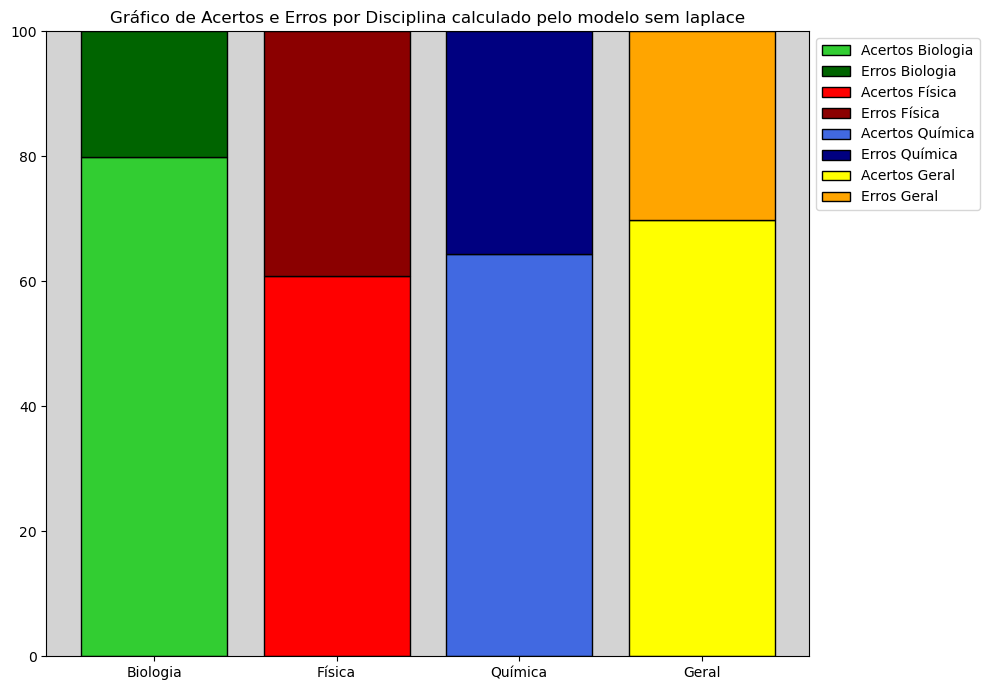

In [48]:
cross_L = pd.crosstab(validacao_biologia.Topic, validacao_biologia.algoL_certa)
display(pd.crosstab(validacao_biologia.algoL_certa, validacao_biologia.Topic))
plt.figure()

fig, ax = plt.subplots(figsize=(10, 7))

categorias = ['Biologia','Física', 'Química', 'Geral']
posicoes = np.arange(1,len(categorias) + 1)

ax.bar(1, taxa_acerto_bio_1 *100, edgecolor='black', color='limegreen', label='Acertos Biologia')
ax.bar(1, ((1 - taxa_acerto_bio_1)*100),edgecolor='black', color='darkgreen', bottom=taxa_acerto_bio_1 *100, label='Erros Biologia')

ax.bar(2, taxa_acerto_ph_1*100, edgecolor='black', color='Red', label='Acertos Física')
ax.bar(2, ((1 - taxa_acerto_ph_1)*100),edgecolor='black', color='darkred', bottom=taxa_acerto_ph_1 *100 , label='Erros Física')

ax.bar(3, taxa_acerto_ch_1*100, edgecolor='black', color='royalblue', label='Acertos Química')
ax.bar(3, ((1 - taxa_acerto_ch_1)*100), edgecolor='black', color='navy', bottom=taxa_acerto_ch_1 *100 , label='Erros Química')

ax.bar(4, taxa_acerto_1[0] *100, edgecolor='black', color='yellow', label='Acertos Geral')
ax.bar(4, (taxa_acerto_1[1] *100), edgecolor='black', color='orange', bottom=taxa_acerto_1[0] *100 , label='Erros Geral')

ax.set_facecolor('lightgray')



ax.set_ylim(0, 100)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(posicoes, categorias, ha='center')
plt.title('Gráfico de Acertos e Erros por Disciplina calculado pelo modelo sem laplace')
plt.tight_layout()  # Ajusta para evitar sobreposição


plt.show()

Esse gráfico de barras mostra a taxa de acerto e a taxa de erro em cada matéria e no geral para o algoritmo com a suavizacao de Laplace

Topic,Biology
algoL_certa,
False,145
True,592


<Figure size 640x480 with 0 Axes>

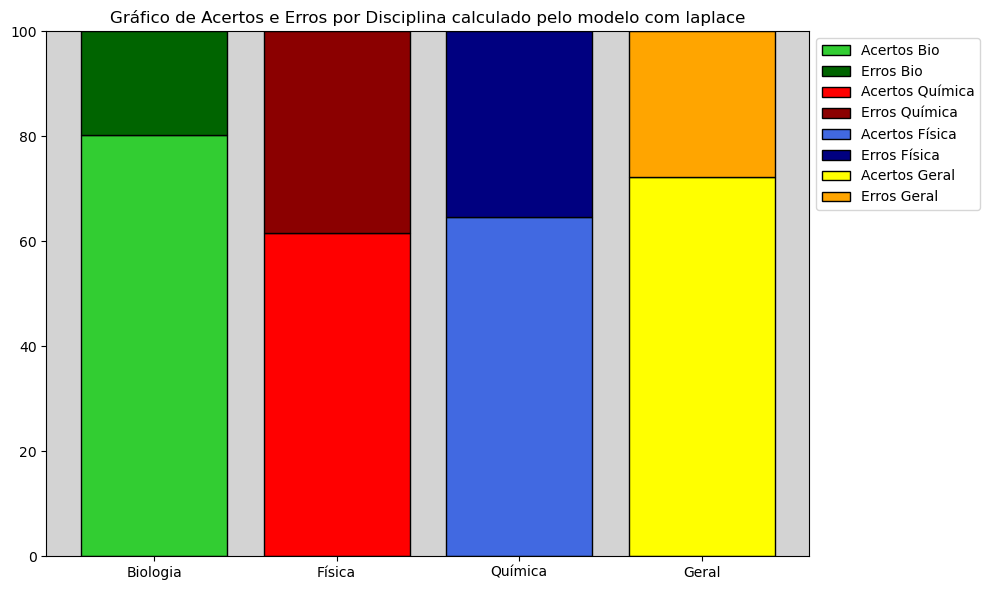

In [47]:
cross_L = pd.crosstab(validacao_biologia.Topic, validacao_biologia.algoL_certa)
display(pd.crosstab(validacao_biologia.algoL_certa, validacao_biologia.Topic))
plt.figure()

fig, ax = plt.subplots(figsize=(10, 6))

categorias = ['Biologia','Física', 'Química','Geral']
posicoes = np.arange(1,len(categorias) + 1)

ax.bar(1, taxa_acerto_bio_L *100, edgecolor='black', color='limegreen', label='Acertos Bio')
ax.bar(1, ((1 - taxa_acerto_bio_L)*100),edgecolor='black', color='darkgreen', bottom=taxa_acerto_bio_L *100, label='Erros Bio')

ax.bar(2, taxa_acerto_ph_L*100, edgecolor='black', color='Red', label='Acertos Química')
ax.bar(2, ((1 - taxa_acerto_ph_L)*100),edgecolor='black', color='darkred', bottom=taxa_acerto_ph_L *100, label='Erros Química')

ax.bar(3, taxa_acerto_ch_L*100, edgecolor='black', color='royalblue', label='Acertos Física')
ax.bar(3, ((1 - taxa_acerto_ch_L)*100), edgecolor='black', color='navy', bottom=taxa_acerto_ch_L *100, label='Erros Física')

ax.bar(4, taxa_acerto_L_log[0] *100, edgecolor='black', color='yellow', label='Acertos Geral')
ax.bar(4, taxa_acerto_L_log[1] *100, edgecolor='black', color='orange', bottom=taxa_acerto_L_log[0] *100, label='Erros Geral')

ax.set_facecolor('lightgray')

ax.set_ylim(0, 100)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(posicoes, categorias, ha='center')
plt.title('Gráfico de Acertos e Erros por Disciplina calculado pelo modelo com laplace')
plt.tight_layout()  # Ajusta para evitar sobreposição

plt.show()

Percebemos com esses gráficos de barras que em geral, nosso algoritmo teve uma boa performance, ele foi melhor proporcionalmente a probabilidade a priori das classificações. Entre as classificações, a maior probabilidade a priori tende a ter uma taxa de acertos maior.

Buscamos a partir daqui fazer gráficos mais conclusivos em relação principalmente às estratégias de performance de Stop-words e N-gramas

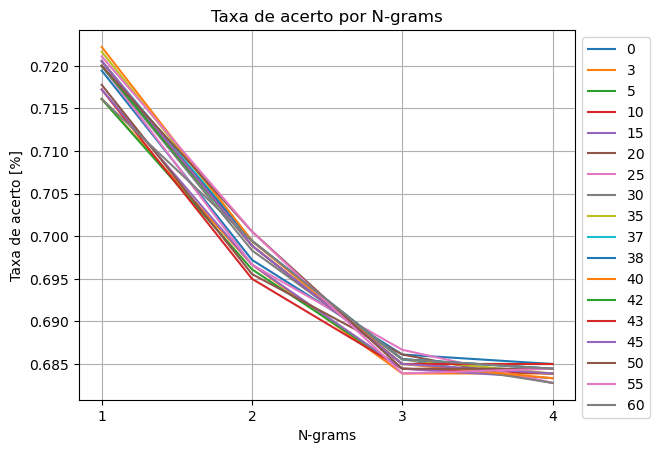

In [49]:
N = np.arange(1,5)

# n_stop_words = np.arange(0, 65, 5)
n_stop_words = [0, 3, 5, 10, 15, 20, 25, 30, 35, 37, 38, 40, 42, 43, 45, 50, 55, 60]

train = pd.read_csv('dados_treino_QUARTETO_Danilo_Leonardo_Thomas.csv') # Reseta o dataframe "train"

lista_acertos_n = []

for n_stop in n_stop_words:
    # print(n_stop) # print para testar
    acertos_n = []
    for n in N:
        # print(n) # print para testar
        list_train = []
        train_atual = train.copy()

        for frase in train_atual.Comment:
            frase = cleanup(frase)
            frase = frase.split()
            list_train.extend([' '.join(frase[i:i+n]) for i in range(len(frase)-n+1)])
            
        serie_train = pd.Series(list_train)

        tabela = serie_train.value_counts()
        stop_words = tabela.index[:n_stop].tolist()
        for i in range(len(stop_words)):
            stop_words[i] = stop_words[i].lower()        
        
        # Limpando os dados de treinamento
        for i, frase in enumerate(train_atual.Comment):
            train_atual.Comment[i] = cleanup_stopwords(frase, stop_words)

        # Construindo uma série de N-gramas baseado nos dados de treino limpos
        list_train: list = []

        for frase in train_atual.Comment:
            frase = frase.split()
            list_train.extend([' '.join(frase[i:i+n]) for i in range(len(frase)-n+1)])
                
        serie_train = pd.Series(list_train)


        train_physics = train_atual.loc[train_atual.Topic == 'Physics']
        train_biology = train_atual.loc[train_atual.Topic == 'Biology']
        train_chemistry = train_atual.loc[train_atual.Topic == 'Chemistry']

        # Gerando as listas de palavras por tópico
        lista_physics = frase_para_palavras(train_physics.Comment)
        lista_biology = frase_para_palavras(train_biology.Comment)
        lista_chemistry = frase_para_palavras(train_chemistry.Comment)

        # Criando séries de frequência de N-gramas
        serie_physics = pd.Series(lista_physics)
        serie_biology = pd.Series(lista_biology)
        serie_chemistry = pd.Series(lista_chemistry)

        # Treinamento
        tabela_c_relativa = serie_chemistry.value_counts(True)
        tabela_p_relativa = serie_physics.value_counts(True)
        tabela_b_relativa = serie_biology.value_counts(True)

        voc = tabela.count()

        # Physics
        tabela_P_raw = serie_physics.value_counts()
        tabela_P_freq = tabela_P_raw.sum()
        tabela_P_voc = tabela_P_raw.count()

        # Chemistry
        tabela_C_raw = serie_chemistry.value_counts()
        tabela_C_freq = tabela_C_raw.sum()
        tabela_C_voc = tabela_C_raw.count()

        # Biology
        tabela_B_raw = serie_biology.value_counts()
        tabela_B_freq = tabela_B_raw.sum()
        tabela_B_voc = tabela_B_raw.count()

        validacao = test.copy()
        
        validacao['algoL_log_certa'] = False

        validacao['algoL_log'] = 'NaN'

        for i, frase in enumerate(test.Comment):
            frase = cleanup_stopwords(frase, stop_words)
            validacao.loc[i, 'algoL_log'] = algoritmo_laplace_log(frase)
        
            if validacao.loc[i, 'algoL_log'] == validacao.loc[i, 'Topic']:
                validacao.loc[i, 'algoL_log_certa'] = True

        acertos_n.append(validacao.algoL_log_certa.value_counts(True).iloc[0])
    lista_acertos_n.append(acertos_n[0])
    

    plt.plot(N, acertos_n, label=n_stop)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.title('Taxa de acerto por N-grams')
plt.xlabel('N-grams')
plt.ylabel('Taxa de acerto [%]')
plt.xticks(N)
plt.show()

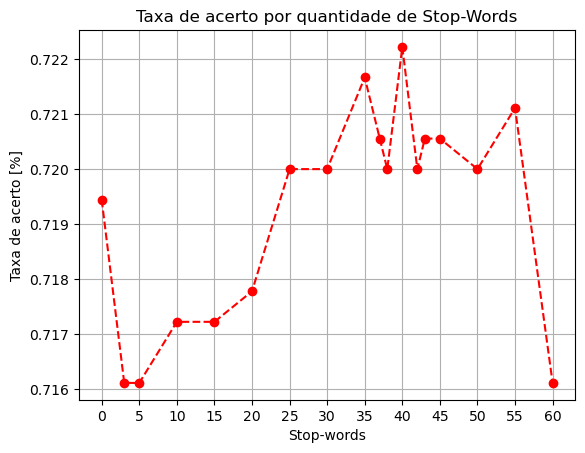

In [50]:
plt.plot(n_stop_words, lista_acertos_n, 'r--')
plt.plot(n_stop_words, lista_acertos_n, 'ro')
plt.grid()
plt.title('Taxa de acerto por quantidade de Stop-Words')
plt.xlabel('Stop-words')
plt.ylabel('Taxa de acerto [%]')
plt.xticks(np.arange(0,65, 5))
plt.show()

In [21]:
# Mostra a taxa de acerto para cada quantidade respectiva de stop-words 
for i, porc in enumerate(lista_acertos_n):
    print(f'{n_stop_words[i]}: {porc}')

0: 0.7194444444444444
3: 0.7161111111111111
5: 0.7161111111111111
10: 0.7172222222222222
15: 0.7172222222222222
20: 0.7177777777777777
25: 0.72
30: 0.72
35: 0.7216666666666667
37: 0.7205555555555555
38: 0.72
40: 0.7222222222222222
42: 0.72
43: 0.7205555555555555
45: 0.7205555555555555
50: 0.72
55: 0.7211111111111111
60: 0.7161111111111111


[Voltar ao Índice](#indice)

___
<div id="conclusao"></div>

### Concluindo

<h2>O algoritmo:</h2>
Para resolver o problema, construimos um modelo de Naive Bayes que obteve um bom grau de sucesso na classificação de comentários do Reddit entre 3 classificações possíveis: as matérias de Física, Química e Biologia. Montamos três algoritmos diferentes, sendo cada um a evolução do último:
1. O primeiro foi um simples algoritmo de Naive Bayes, sem mas nenhuma tecnica utilizada. Com esse foi atingida uma taxa de acerto de 69,83%.
2. Em seguida, usamos a técnica conhecida como Laplace para resolver o problema. Esse algoritmo soma 1 a frequência de todas as palavras; assim, quando a palavra não está na lista das palavras de treino, sua frequência passa de 0 pra 1. Esse fator utilizado na soma é chamado de "alpha".
3. Por último, aprimoramos o algorítmo com Laplace usando uma simplificação com logarítmos. Isso porque antes a probabilidade da frase toda era o produto da probabilidade de cada palavra, as quais são números extremamente pequenos. Assim, conforme o sistema vai fazendo essa multiplicação, vai trabalhando com números cada vez menores, o que pode atrapalhar essa conta. Por isso, é possível utilizar a seguinte propriedade de logarítmos e transformar a multiplicação em uma soma, o que ajuda muito no processamento dos dados: 
$$\log(a \times b \times c) = \log(a) + \log(b) + \log(c)$$
<br>
<br>
Para uma melhor análise dos resultados obtidos, plotamos dois gráficos que podem ser vistos acima. O primeiro deles mostra a performance do classificador para cada quantidade de palavras usadas (n-gramas - bigramas = 2 palavras) e para cada quantidade de stop-words utilizada. Ao analisá-lo, é visível uma clara superioridade no classificador que usa apenas uma palavra por vez, o que deve ser consequência de uma base de treinamento não tão grande.
<br>
A partir do 1 gráfico, usamos as performances com apenas uma palavra de n-grama para comparar as diferentes quantidades de stop-words. Ao análisar o 2° gráfico vê-se que a taxa de acerto máxima foi com 40 stop-words.
<br>
Por essas razões, deixamos o código principal (antes dos gráficos) com 1 n-grama e 40 stop-words. 
<br>
<br>
Apesar de termos implementado diversas técnicas no nosso classificador, não conseguimos melhorá-lo mais que a taxa de acerto de 72,22%. A principal razão disso são as limitações existentes, dentre elas: 

- A base de dados não é grande o suficiente; ao realizar testes com uma base de dados maior, como por exemplo com 5.000 frases de treino e outras 5.000 frases de teste, o resultado melhorou significativamente (em comparação às 1.800 frases utilizadas nesse classificador).
- Na base de dados, existem diversos comentários que são impossíveis de classificar e acabam sendo considerados de biologia, já que na nossa base de treino essa é a matéria mais comum. Alguns exemplos dessas frases são "thank you", "I agree", "makes sense", "I see, thanks!", entre outras. OBS: Nós até tentamos tirar as frases mais curtas da base de dados, mas isso não melhorou a performace. 
<br>

<br>
Uma última opção para melhorar a performance do naive-bayes seria fazer a estratégia de Stemming e Lemmatization, se tratando de tratar as palavras para transformá-las em sua forma “bruta’’ e o processo contrário, transformar palavras com gramática errada para a gramática certa da grafia original dessa palavra. Essas estratégias estão formalmente presentes também no artigo de explicação do algoritmo Naive Bayes.
Ainda sim, essa estratégia levaria um tempo considerável para ser aplicada e a estimativa de melhora dos resultados é pequena. Um esforço, por exemplo, de captar mais dados de novas fontes poderia ser em geral mais produtivo para o nosso problema de classificação do que aplicar essas estratégias ao modelo atual. Mas seria uma próxima implementação para melhorar ainda mais o modelo
<br>


<h2>Para onde podemos levar essas conclusões:</h2>

Dado o algoritmo naive-bayes que construímos, podemos perceber que com um código relativamente simples, é possível ter um algoritmo de classificação com bom desempenho. Isso pode ser usado em casos gerais onde existe um problema de classificação dado alguns fatores, por exemplo:

- Doenças que temos dados o suficiente para calcular a probabilidade da doença dado um marcador biológico em um exame podem ser diagnosticadas com uma boa performance a partir de um modelo Naive -bayes
- EX 2


Referências dos exemplos:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5203736/



<h1>FALTA FAZER:</h1>


- explicar pq não pode treinar com mensagens classificadas pelo próprio classificador
- explicar 1 uso1 do Naive Bayes (o do hospital do Danilo e mais algum que precisa pesquisar/pensar)
- sugerir possíveis melhorias ou outras abordagens (indicar como fazer e o a fonta de pesquisa)

___
<div id="referencias"></div>

## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

[Voltar ao Índice](#indice)